In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

RANDOM_STATE = 42
DATA_PATH = "housing.csv"


In [ ]:
housing = pd.read_csv(DATA_PATH)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Data Exploration

In [ ]:
print("Shape:", housing.shape)
housing.info()

Shape: (20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
housing.isna().sum().sort_values(ascending=False)

total_bedrooms        207
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [ ]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

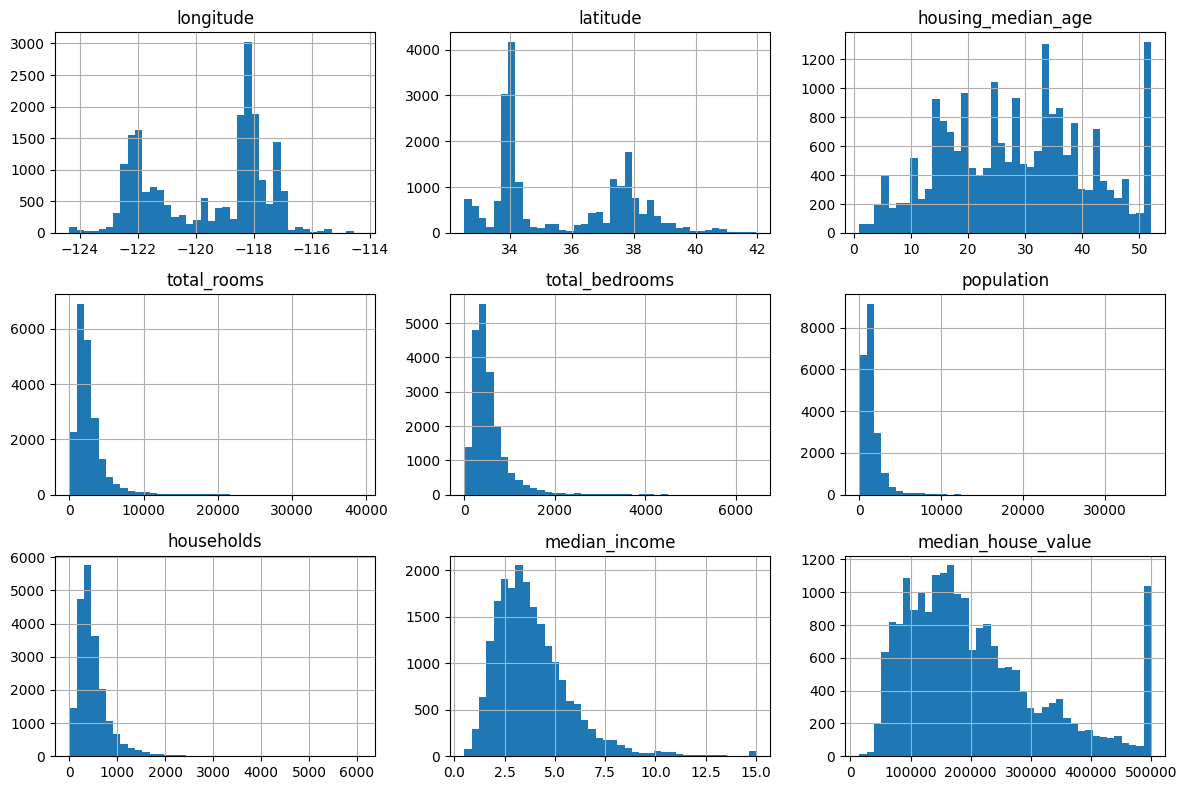

In [ ]:
housing.hist(bins=40, figsize=(12, 8))
plt.tight_layout()
plt.show()

Most numerical features exhibit strong right-skewness, with a small number of census blocks having very large values. This suggests heterogeneous neighborhood sizes and motivates the use of robust models and feature engineering.

## total_rooms, total_bedrooms
The distributions of total rooms and total bedrooms are heavily right-skewed, indicating that most census block groups contain relatively few rooms, while a small number of areas are significantly larger. This motivates using ratio-based features rather than raw counts

## population, households
Population and household counts are highly skewed, reflecting substantial variability in block group sizes. These features capture scale effects but may be more informative when normalized by household counts.

## median_income
Median income shows a more compact and approximately unimodal distribution, with fewer extreme outliers compared to count-based variables. This indicates a stable socio-economic signal across regions.

## median_house_value (Very important feature)
The target variable shows a noticeable spike at the upper bound, confirming the presence of a hard price cap in the dataset. This censoring effect can limit achievable performance and distort error metrics at the high end.

In [ ]:
# Select numeric features only
numeric_housing = housing.select_dtypes(include=[np.number])

# Correlation matrix
corr_matrix = numeric_housing.corr()

# Correlation with target
corr_target = (
    corr_matrix["median_house_value"]
    .sort_values(ascending=False)
)

corr_target

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

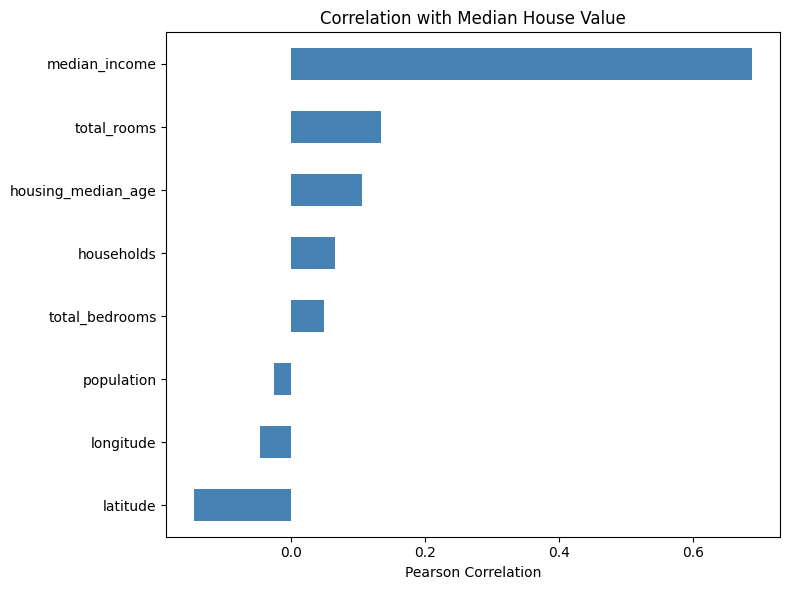

In [ ]:
plt.figure(figsize=(8, 6))
corr_target.drop("median_house_value").plot(
    kind="barh",
    color="steelblue"
)
plt.gca().invert_yaxis()
plt.title("Correlation with Median House Value")
plt.xlabel("Pearson Correlation")
plt.tight_layout()
plt.show()

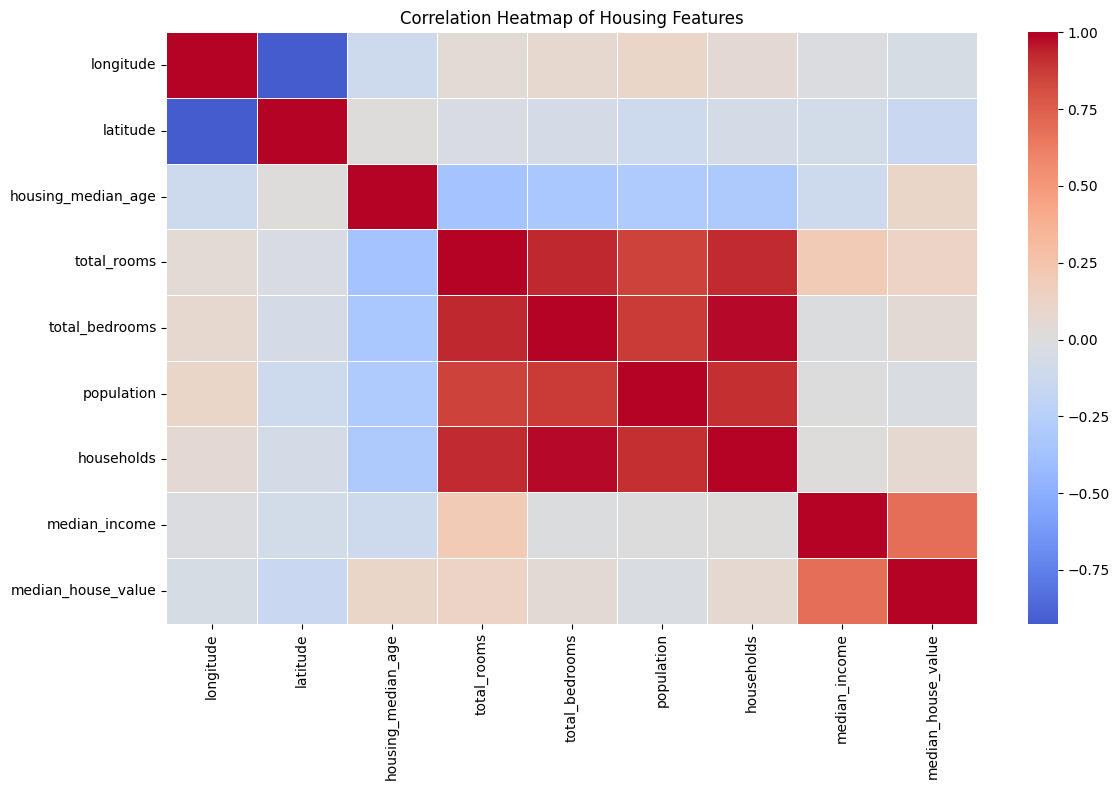

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation Heatmap of Housing Features")
plt.tight_layout()
plt.show()

In [ ]:
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

housing["income_cat"].value_counts().sort_index()


income_cat
1     822
2    6581
3    7236
4    3639
5    2362
Name: count, dtype: int64

Instead of a simple random split, we used stratified sampling based on median income to ensure that both training and test sets preserve the original income distribution. This improves the reliability and stability of model evaluation.

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
for train_idx, test_idx in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_idx].drop(columns=["income_cat"])
    strat_test_set  = housing.loc[test_idx].drop(columns=["income_cat"])

print("Train:", strat_train_set.shape, "Test:", strat_test_set.shape)

Train: (16512, 10) Test: (4128, 10)


In [ ]:
X_train = strat_train_set.drop("median_house_value", axis=1)
y_train = strat_train_set["median_house_value"].copy()

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [ ]:
def add_extra_features(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    X["rooms_per_household"] = X["total_rooms"] / X["households"]
    X["population_per_household"] = X["population"] / X["households"]
    X["bedrooms_per_room"] = X["total_bedrooms"] / X["total_rooms"]
    return X

feature_adder = FunctionTransformer(add_extra_features, validate=False)

In [ ]:
housing_fe = add_extra_features(housing)

numeric_fe = housing_fe.select_dtypes(include=[np.number])
corr_fe = numeric_fe.corr()

corr_fe["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

## Feature Engineering
No original features were discarded during feature engineering. Instead, additional ratio-based features were introduced to enrich the representation while preserving all available information since tree-based ensemble models can naturally handle correlated and redundant features

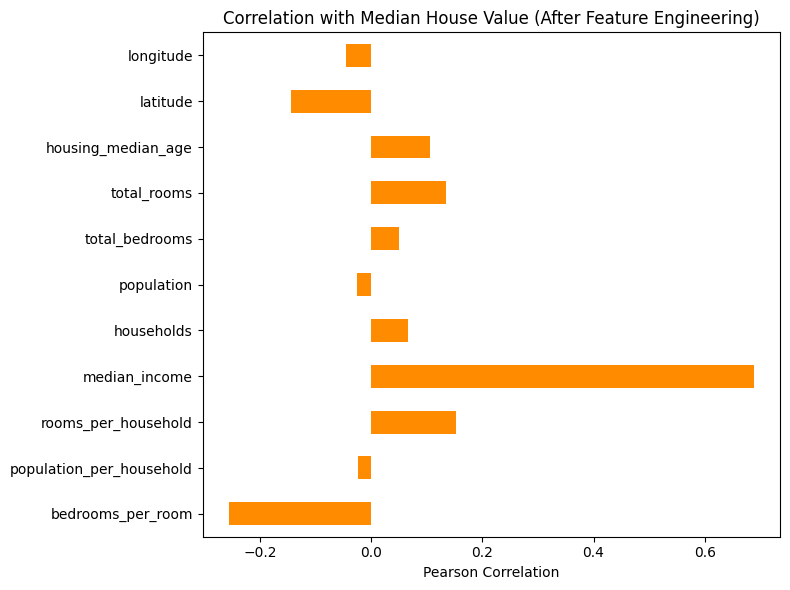

In [ ]:
plt.figure(figsize=(8, 6))
corr_fe["median_house_value"].drop("median_house_value").plot(
    kind="barh",
    color="darkorange"
)
plt.gca().invert_yaxis()
plt.title("Correlation with Median House Value (After Feature Engineering)")
plt.xlabel("Pearson Correlation")
plt.tight_layout()
plt.show()

I used a ColumnTransformer to apply median imputation and scaling to numerical features and one-hot encoding to categorical features, all inside a pipeline to prevent data leakage and ensure reproducibility.

In [ ]:
num_features = X_train.drop(columns=["ocean_proximity"]).columns.tolist()
cat_features = ["ocean_proximity"]

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
])

Checking several regression models to find the best one

In [ ]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
candidates = [
    ("ridge", Ridge(random_state=RANDOM_STATE)),
    ("gbrt", GradientBoostingRegressor(random_state=RANDOM_STATE)),
    ("hgb", HistGradientBoostingRegressor(random_state=RANDOM_STATE)),
    ("rf", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)),
    ("extra", ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=-1)),
]

param_distributions = {
    "ridge": {
        "model__alpha": np.logspace(-1, 2, 8)
    },

    "gbrt": {
        "model__n_estimators": [200, 400],
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [2, 3],
        "model__subsample": [0.8, 1.0]
    },

    "hgb": {
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [None, 10],
        "model__max_leaf_nodes": [31, 63],
        "model__min_samples_leaf": [20, 50]
    },

    "rf": {
        "model__n_estimators": [300, 500],
        "model__max_depth": [None, 30, 50],
        "model__min_samples_leaf": [1, 2],
        "model__max_features": ["sqrt", 0.8],
        "model__bootstrap": [True]
    },

    "extra": {
        "model__n_estimators": [300, 500],
        "model__max_depth": [None, 30, 50],
        "model__min_samples_leaf": [1, 2],
        "model__max_features": ["sqrt", 0.8]
    }
}

In [ ]:
import time

results = []
best_estimators = {}

N_ITER = 10
CV = 3

for name, estimator in candidates:
    pipe = Pipeline(steps=[
        ("feature_adder", feature_adder),
        ("preprocess", preprocess),
        ("model", estimator)
    ])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions[name],
        n_iter=N_ITER,
        cv=CV,
        scoring="neg_root_mean_squared_error",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )

    t0 = time.time()
    search.fit(X_train, y_train)
    dt = time.time() - t0

    best_rmse = -search.best_score_
    best_estimators[name] = search.best_estimator_

    results.append({
        "model": name,
        "best_cv_rmse": best_rmse,
        "time_sec": dt,
        "best_params": search.best_params_
    })

    print(f"{name}: RMSE={best_rmse:,.2f} | time={dt:,.1f}s")

c:\Users\This PC\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\model_selection\_search.py:324: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
ridge: RMSE=69,288.17 | time=6.4s
Fitting 3 folds for each of 10 candidates, totalling 30 fits
gbrt: RMSE=50,284.40 | time=38.3s
Fitting 3 folds for each of 10 candidates, totalling 30 fits
hgb: RMSE=47,938.18 | time=6.9s
Fitting 3 folds for each of 10 candidates, totalling 30 fits
rf: RMSE=49,869.80 | time=97.4s
Fitting 3 folds for each of 10 candidates, totalling 30 fits
extra: RMSE=51,431.59 | time=62.0s


In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    }

In [ ]:
final_results = []

for name, model in best_estimators.items():
    metrics = evaluate_model(model, X_test, y_test)

    final_results.append({
        "model": name,
        "RMSE": metrics["RMSE"],
        "MAE": metrics["MAE"],
        "R2": metrics["R2"]
    })

In [ ]:
final_df = (
    pd.DataFrame(final_results)
    .sort_values("RMSE")
    .reset_index(drop=True)
)

final_df

,model,RMSE,MAE,R2
0,hgb,45562.367267,30576.582062,0.840719
1,rf,46643.399571,30738.503072,0.833071
2,gbrt,48556.908513,33541.565356,0.819094
3,extra,48875.296016,33585.125941,0.816714
4,ridge,67477.123716,49816.106653,0.650648


In [ ]:
extra_models = [
    ("linreg", LinearRegression()),
    ("knn", KNeighborsRegressor()),
    ("svr", SVR()),
]

extra_param_distributions = {
    "linreg": None,

    "knn": {
        "model__n_neighbors": list(range(3, 41, 2)),
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2],
    },

    "svr": {
        "model__kernel": ["rbf"],
        "model__C": [10, 30, 100],
        "model__epsilon": [0.05, 0.1, 0.2],
        "model__gamma": ["scale"],
    },
}

In [ ]:
new_rows = []
new_best_estimators = {}

for name, estimator in extra_models:
    pipe = Pipeline(steps=[
        ("feature_adder", feature_adder),
        ("preprocess", preprocess),
        ("model", estimator)
    ])

    if extra_param_distributions[name] is None:
        pipe.fit(X_train, y_train)
        best_est = pipe
    else:
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=extra_param_distributions[name],
            n_iter=12 if name == "knn" else 8,
            cv=3,
            scoring="neg_root_mean_squared_error",
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=0
        )
        search.fit(X_train, y_train)
        best_est = search.best_estimator_

    new_best_estimators[name] = best_est

    metrics = evaluate_model(best_est, X_test, y_test)
    new_rows.append({
        "model": name,
        "RMSE": metrics["RMSE"],
        "MAE": metrics["MAE"],
        "R2": metrics["R2"]
    })

new_df = pd.DataFrame(new_rows)
new_df

,model,RMSE,MAE,R2
0,linreg,67346.879958,49775.595699,0.651995
1,knn,58177.263653,40035.355047,0.740309
2,svr,92978.974051,65341.788448,0.336685


In [ ]:
combined_df = (
    pd.concat([final_df, new_df], ignore_index=True)
    .sort_values("RMSE")
    .reset_index(drop=True)
)

best_estimators.update(new_best_estimators)

combined_df


,model,RMSE,MAE,R2
0,hgb,45562.367267,30576.582062,0.840719
1,rf,46643.399571,30738.503072,0.833071
2,gbrt,48556.908513,33541.565356,0.819094
3,extra,48875.296016,33585.125941,0.816714
4,knn,58177.263653,40035.355047,0.740309
5,linreg,67346.879958,49775.595699,0.651995
6,ridge,67477.123716,49816.106653,0.650648
7,svr,92978.974051,65341.788448,0.336685


## Obtained results:
Tree-based ensemble models significantly outperform linear and distance-based approaches, confirming the highly non-linear and heterogeneous nature of the housing price prediction task. I have decided to further optimize the hgb model to see how much it can get improved

In [ ]:
param_grid_hgb = {
    "model__learning_rate": [0.03, 0.05, 0.07],
    "model__max_depth": [None, 8, 12],
    "model__max_leaf_nodes": [63, 127, 255],
    "model__min_samples_leaf": [10, 20, 30],
    "model__l2_regularization": [0.0, 0.1, 1.0]
}

hgb_pipe = Pipeline(steps=[
    ("feature_adder", feature_adder),
    ("preprocess", preprocess),
    ("model", HistGradientBoostingRegressor(
        random_state=RANDOM_STATE,
        early_stopping=True
    ))
])

grid_hgb = GridSearchCV(
    estimator=hgb_pipe,
    param_grid=param_grid_hgb,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_hgb.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__l2_regularization': [0.0, 0.1, ...], 'model__learning_rate': [0.03, 0.05, ...], 'model__max_depth': [None, 8, ...], 'model__max_leaf_nodes': [63, 127, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, t

In [ ]:
print("Best HGB params:")
print(grid_hgb.best_params_)

print("\nBest CV RMSE:")
print(grid_hgb.best_score_)

Best HGB params:
{'model__l2_regularization': 0.1, 'model__learning_rate': 0.07, 'model__max_depth': None, 'model__max_leaf_nodes': 127, 'model__min_samples_leaf': 10}

Best CV RMSE:
-47820.187692305946


In [ ]:
final_hgb = grid_hgb.best_estimator_

hgb_pred = final_hgb.predict(X_test)

hgb_final_metrics = {
    "model": "final_hgb",
    "RMSE": np.sqrt(mean_squared_error(y_test, hgb_pred)),
    "MAE": mean_absolute_error(y_test, hgb_pred),
    "R2": r2_score(y_test, hgb_pred)
}

hgb_final_metrics

{'model': 'final_hgb',
 'RMSE': np.float64(44951.59213545862),
 'MAE': 29951.534539654687,
 'R2': 0.8449610713880438}

In [ ]:
final_df_with_tuned = (
    pd.concat([final_df, pd.DataFrame([hgb_final_metrics])])
    .sort_values("RMSE")
    .reset_index(drop=True)
)

final_df_with_tuned


,model,RMSE,MAE,R2
0,final_hgb,44951.592135,29951.534540,0.844961
1,hgb,45562.367267,30576.582062,0.840719
2,rf,46643.399571,30738.503072,0.833071
3,gbrt,48556.908513,33541.565356,0.819094
4,extra,48875.296016,33585.125941,0.816714
5,ridge,67477.123716,49816.106653,0.650648


In [ ]:
import joblib
joblib.dump(final_hgb, "hgb_final.joblib")

['hgb_final.joblib']